In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Tạo engine kết nối với SQL Server sử dụng SQLAlchemy
engine = create_engine('mssql+pyodbc://WHITEKING\WHITEKING/vietlott?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes')

# Sử dụng engine để thực hiện truy vấn và lấy dữ liệu vào DataFrame
prize_result = pd.read_sql('SELECT * FROM vietlott.power.prize_result_power', engine)
draw_result = pd.read_sql('SELECT * FROM vietlott.power.draw_result_power', engine)

# Thống kê số lần xuất hiện

In [69]:
frequency_number = draw_result.iloc[:, 2:].stack().value_counts().sort_values(ascending=True)
frequency_number

39    112
37    112
06    113
30    113
07    114
16    116
02    117
04    117
25    118
26    118
28    118
38    119
17    119
27    120
54    121
36    121
21    122
15    122
10    123
13    124
42    126
45    127
14    127
55    128
29    130
47    130
05    131
18    131
19    131
24    132
33    132
31    133
50    133
11    134
46    134
48    135
40    135
32    135
08    135
52    136
20    136
35    137
01    137
12    137
44    137
53    138
49    139
34    141
43    141
51    142
03    144
09    144
23    145
41    145
22    148
Name: count, dtype: int64

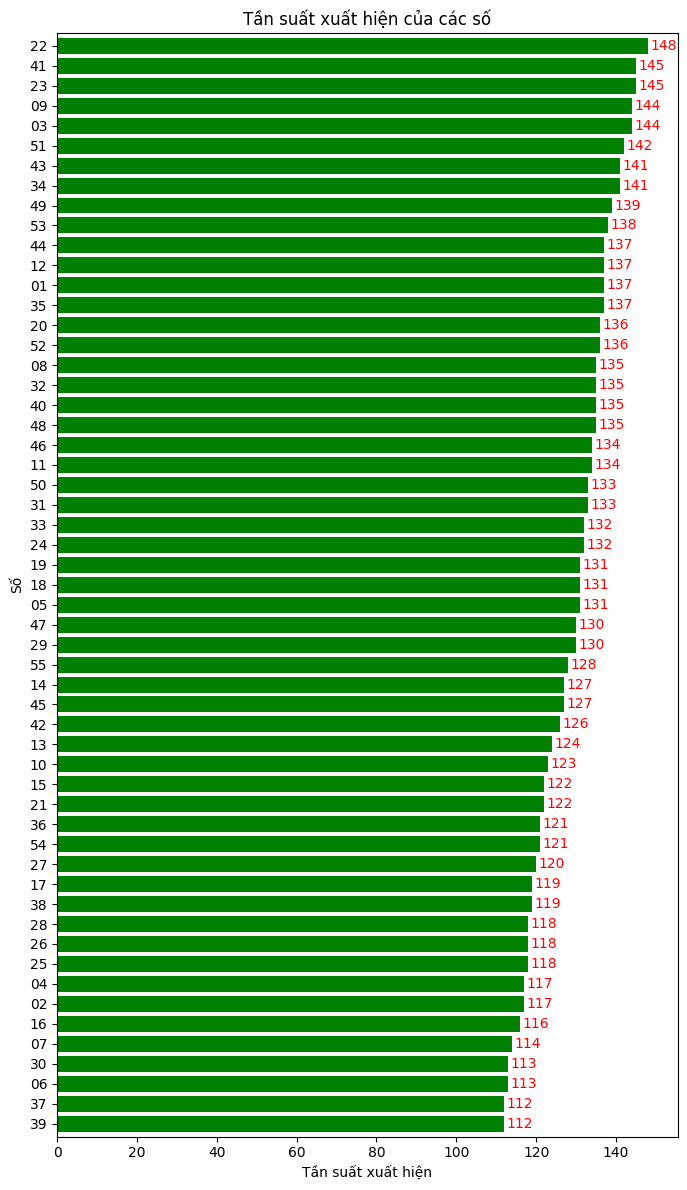

In [70]:
frequency_number.plot(kind='barh', figsize=(7, 12), color='green', width=0.8)
plt.xlabel('Tần suất xuất hiện')
plt.ylabel('Số')
plt.title('Tần suất xuất hiện của các số')

# Hiển thị số liệu bên phải mỗi cột và thay đổi màu sắc
for i, (index, value) in enumerate(frequency_number.items()):
    plt.text(value + 0.5, i, str(value), color='red', va='center')

plt.tight_layout()
plt.show()

In [30]:
# Lọc và lấy chỉ cột draw_ID từ prize_result
# jackpot_draw_ID = prize_result.loc[(prize_result['number_of_prizes'] >= 1) & (prize_result['prize'] == 'Jackpot 1'), 'draw_ID']
jackpot_draw_ID = prize_result.query("number_of_prizes >= 1 and prize == 'Jackpot 1'")['draw_ID']

# jackpot_draw_result = (
#     draw_result
#     .merge(jackpot_draw_ID.to_frame(), on='draw_ID', how='inner', indicator=True)
#     .drop(columns=['_merge'])
# )
jackpot_draw_result = draw_result[draw_result['draw_ID'].isin(jackpot_draw_ID)].reset_index(drop=True)
jackpot_draw_result


,draw_ID,draw_date,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6,ball_special
0,119,2018-05-05,16,32,33,37,40,48,15
1,125,2018-05-19,33,35,45,52,53,55,25
2,131,2018-06-02,05,07,17,22,32,33,06
3,139,2018-06-21,02,08,19,23,25,33,32
4,149,2018-07-14,04,19,23,34,38,50,01
5,159,2018-08-07,03,09,15,20,39,49,04
6,194,2018-10-27,08,09,15,21,44,49,16
7,201,2018-11-13,03,25,26,32,41,47,05
8,228,2019-01-15,04,06,13,22,29,30,52
9,268,2019-04-20,08,10,12,24,40,44,51


In [32]:
# Đọc dữ liệu
data = {
    'draw_ID': [119, 125, 131, 139],
    'draw_date': ['2018-05-05', '2018-05-19', '2018-06-02', '2018-06-21'],
    'ball_1': [16, 33, 5, 2],
    'ball_2': [32, 35, 7, 8],
    'ball_3': [33, 45, 17, 19],
    'ball_4': [37, 52, 22, 23],
    'ball_5': [40, 53, 32, 25],
    'ball_6': [48, 55, 33, 33],
    'ball_special': [15, 25, 6, 32]
}

df = pd.DataFrame(data)

# Loại bỏ các cột không cần thiết
df = df.drop(columns=['draw_ID', 'draw_date'])

# Tính tần suất xuất hiện của các số
frequency = df.stack().value_counts()

print(frequency)

33    4
32    3
25    2
16    1
19    1
8     1
2     1
6     1
22    1
17    1
7     1
5     1
55    1
53    1
52    1
45    1
35    1
15    1
48    1
40    1
37    1
23    1
Name: count, dtype: int64
